In [1]:
import os
import sys

sys.path.append(os.path.abspath("../../"))


import my_utils as utils
import pandas as pd

BASE_PATH = os.path.join("results", "late_fusion")
INSTRUCTERC_BASE_PATH = os.path.join("results", "InstructERC")

# Late Fusion

In diesem Abschnitt werden die erzielten Ergebnisse und das Late-Fusion Modells weitergehend untersucht, um folgenden Forschungsfragen zu beantworten:
- Wie ist die performance auf IEMOCAP und MELD
- Gibt es Änderungen in der Klassifizierung im Vergleich zum normalen InstructERC
  - Wenn ja, welche?
- Was wird durch die Akustik erkannt?
  - Was wird nur durch Akustik erkannt?
  - Gibt es Verbesserungen in bestimmten Emotionen
- Kann das Modell das volle Potenzial aus beiden Modalitäten ausnutzen?
- Wie verhält sich das Gating-modul?
  - was passiert bei verrauschtem Audio/Text Input?
- passt das alignment der beiden Feature vectoren bei gleicher Emotion?
  - muss die Klassifizierungsschicht zwei Latenzräume lernen?

## Meld

In [2]:
DATASET = "Meld"


def get_result_dataframe(dataset: str) -> pd.DataFrame:
    normal_path = os.path.join(BASE_PATH, dataset, "preds_test.json")
    audio_path = os.path.join(BASE_PATH, dataset, "preds_test_no_text.json")
    text_path = os.path.join(BASE_PATH, dataset, "preds_test_no_audio.json")

    normal_df = utils.build_result_dataframe(normal_path)
    audio_df = utils.build_result_dataframe(audio_path)
    text_df = utils.build_result_dataframe(text_path)
    ierc_df = utils.get_instructerc_results(INSTRUCTERC_BASE_PATH, dataset)

    assert len(normal_df) == len(audio_df) == len(ierc_df) == len(text_df)

    results = utils.merge_result_dataframes([normal_df, audio_df, ierc_df, text_df], ["normal", "audio", "ierc", "text"])
    results = utils.extract_dialogue_information(results)

    return results


df = get_result_dataframe(DATASET)
df.head(3)

,input,output,target,certainty,gate,input_audio,output_audio,certainty_audio,input_ierc,output_ierc,utterance,dialogue_length,utterence_length,input_text,output_text,certainty_text
index,,,,,,,,,,,,,,,,
0,Now you are expert of sentiment and emotional ...,neutral,surprise,0.631836,"[1.0625, 0.73583984375]",Now you are expert of sentiment and emotional ...,neutral,0.459229,Now you are expert of sentiment and emotional ...,neutral,Why do all youre coffee mugs have numbers on ...,1,11,Now you are expert of sentiment and emotional ...,neutral,0.499023
1,Now you are expert of sentiment and emotional ...,neutral,anger,0.909180,"[1.1181640625, 1.0634765625]",Now you are expert of sentiment and emotional ...,neutral,0.427246,Now you are expert of sentiment and emotional ...,neutral,Oh. Thats so Monica can keep track. That way ...,2,22,Now you are expert of sentiment and emotional ...,neutral,0.839844
2,Now you are expert of sentiment and emotional ...,neutral,neutral,0.925781,"[1.228515625, 1.048828125]",Now you are expert of sentiment and emotional ...,neutral,0.556152,Now you are expert of sentiment and emotional ...,neutral,Y'know what?,3,2,Now you are expert of sentiment and emotional ...,neutral,0.879883


In [3]:
df["output_ierc"].value_counts()

output_ierc
neutral     1054
joy          473
anger        402
surprise     343
sadness      131
disgust      120
fear          87
Name: count, dtype: int64

### Performance

Dafür wird der gewichtete F1 Score berechnet:
\begin{equation}
    F1 = 2\cdot\frac{precision\cdot recall}{precision + recall}
\end{equation}
Dieser wird für jedes Label berechnet und durch die Anzahl der label normalisiert.
Dadurch bekommt jedes Label, unabhängig von der Anzah, die selbe Gewichtung im Gesamtergebnis.

In [4]:
from sklearn.metrics import f1_score

labels = df["target"].value_counts().index.to_list()

df["any_correct"] = df[
    (df["output_ierc"] == df["target"]) | (df["output_audio"] == df["target"]) | (df["output"] == df["target"])
]["target"]
df.loc[df["any_correct"].isna(), "any_correct"] = df.loc[
    df["any_correct"].isna(), "output_ierc"
]

fusion_model_f1 = f1_score(
    df["target"], df["output"], average="weighted", labels=labels
)
audio_only_f1 = f1_score(
    df["target"], df["output_audio"], average="weighted", labels=labels
)
text_only_f1 = f1_score(
    df["target"], df["output_ierc"], average="weighted", labels=labels
)
ideal_f1 = f1_score(df["target"], df["any_correct"], average="weighted", labels=labels)

print(f"F1-Score des Fusion Modells: {100*fusion_model_f1:.2f}")
print(f"F1-Score mit nur audio input: {100*audio_only_f1:.2f}")
print(f"F1-Score des Basismodells: {100*text_only_f1:.2f}")
print(f"Änderung: {(100*fusion_model_f1 - 100*text_only_f1):.2f}")
print(f"Idealer F1-Score: {100*ideal_f1:.2f}")

F1-Score des Fusion Modells: 69.05
F1-Score mit nur audio input: 34.25
F1-Score des Basismodells: 65.10
Änderung: 3.95
Idealer F1-Score: 81.18


Betrachten wir uns nun die Confusion-Matrix des fusionination Modells.
In Klammern ist der prozentuale Anteil der Zeile angegeben. Daran orientiert sich ebenfalls auch die Farbgebung.

c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 7 in image.
c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: images/fusion_meld_combined_cm.png


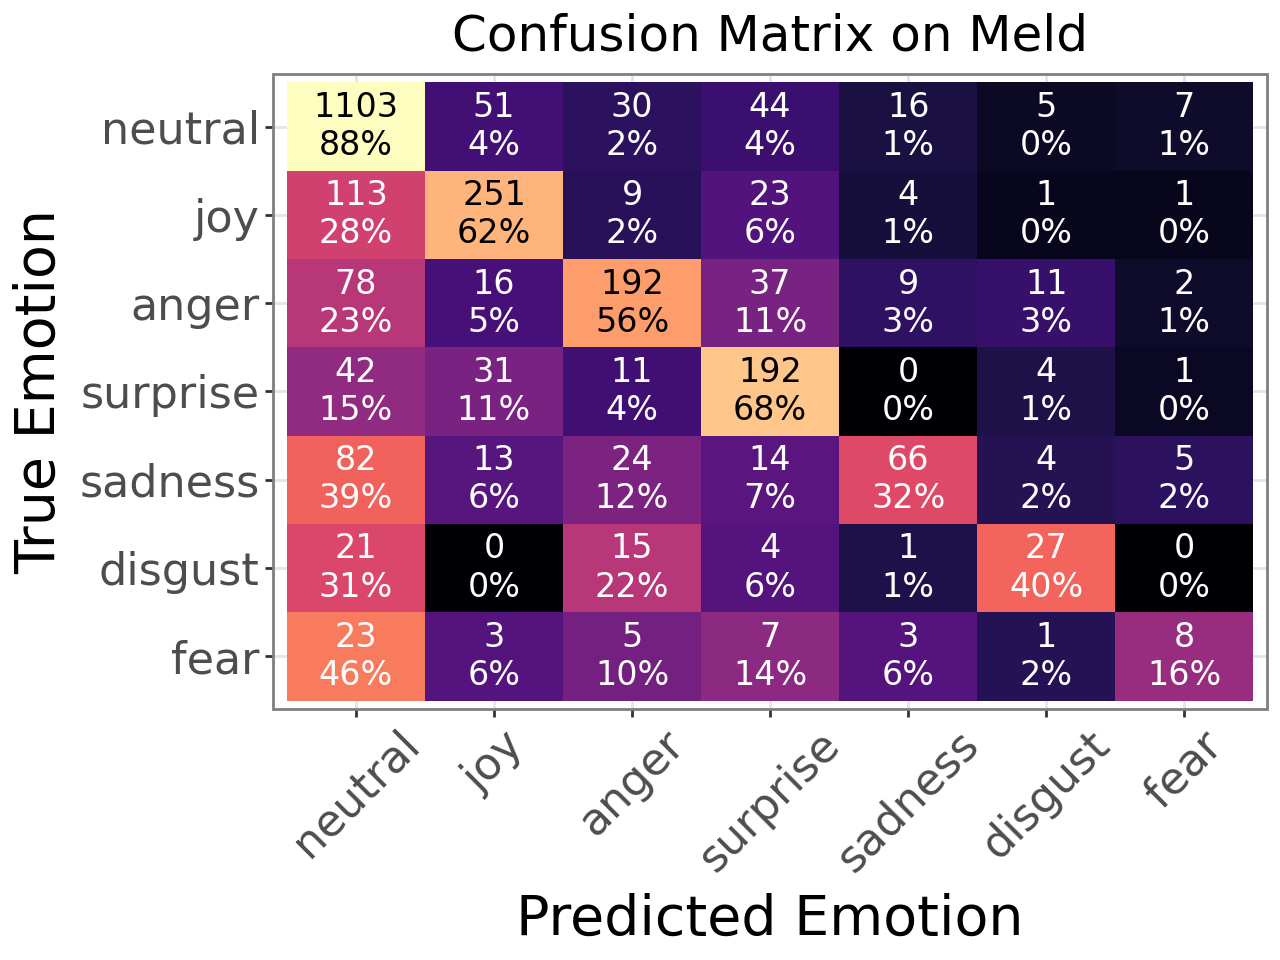

In [5]:
utils.print_confusion_matrix(
    df,
    target_labels=labels[::-1],
    output_column="output",
    name="images/fusion_meld_combined_cm.png",
    title="Confusion Matrix on Meld",
)

In [6]:
from sklearn.metrics import confusion_matrix

print(labels)

print(confusion_matrix(df["target"], df["output"], labels=labels))

['neutral', 'joy', 'anger', 'surprise', 'sadness', 'disgust', 'fear']
[[1103   51   30   44   16    5    7]
 [ 113  251    9   23    4    1    1]
 [  78   16  192   37    9   11    2]
 [  42   31   11  192    0    4    1]
 [  82   13   24   14   66    4    5]
 [  21    0   15    4    1   27    0]
 [  23    3    5    7    3    1    8]]


Es können entgegengesetzte Emotionen definiert werden. Die eine Klasse bilden die positiven Emotionen "joy" und "surprise", die andere negative Emotionen "sadness", "anger", "disgust" und "fear".
Zwischen diesen beiden Gruppen gibt es so gut wie keine Verwechselungen, wie die Confusion-Matrix, mit einteilung in positiv und negativ, zeigt.

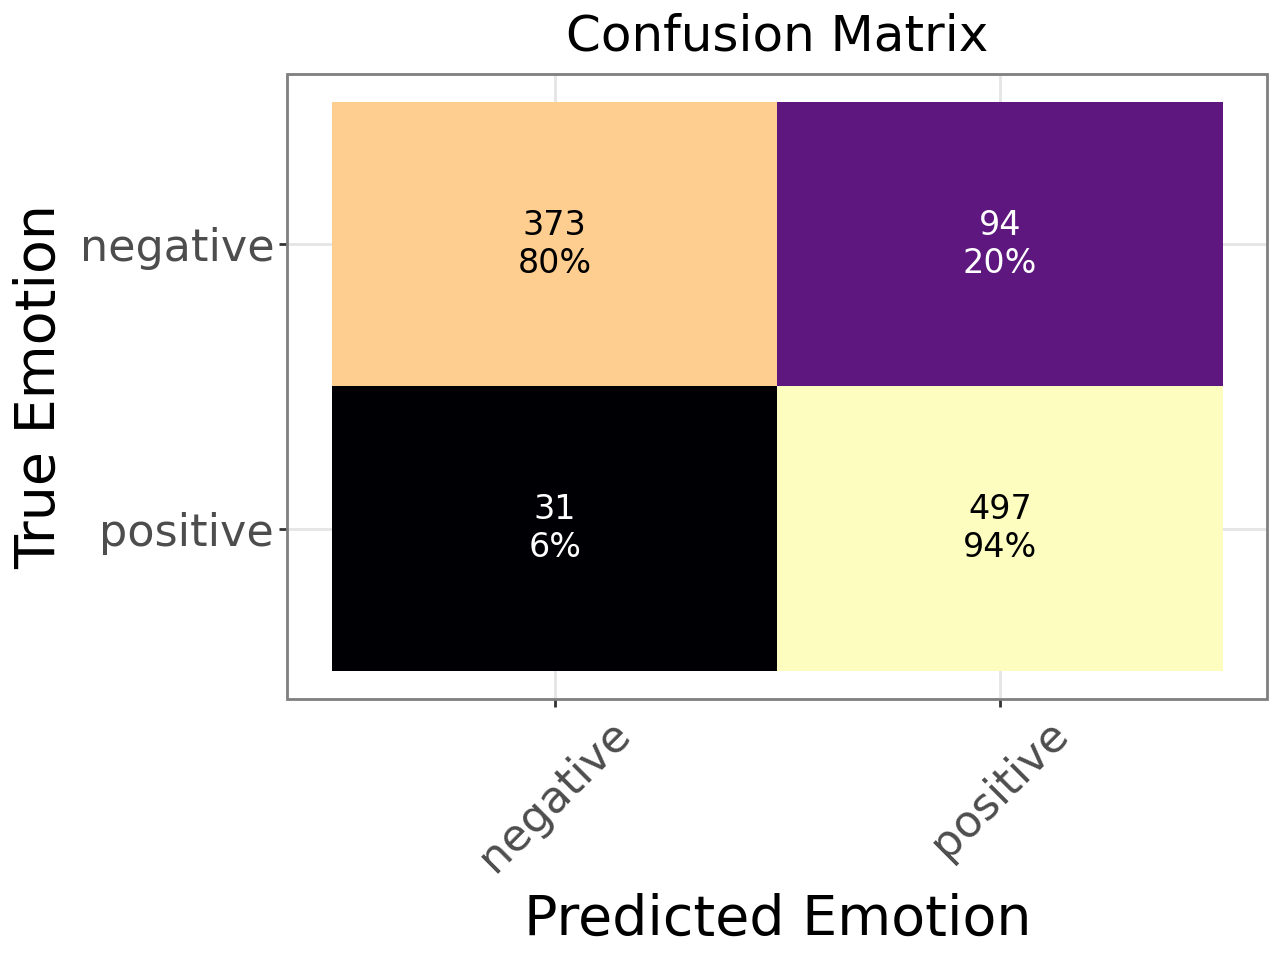

In [7]:
from functools import partial

meld_positive_emotions = ["joy", "surprise"]
meld_negative_emotions = ["anger", "sadness", "disgust", "fear"]


meld_classify_sentiment = partial(utils.classify_sentiment, positive=meld_positive_emotions, negative=meld_negative_emotions)

df["emotion_sentiment"] = df["target"].apply(meld_classify_sentiment)
df["emotion_sentiment_prediction"] = df["output"].apply(meld_classify_sentiment)


utils.print_confusion_matrix(df, target_labels=["positive", "negative"], output_column="emotion_sentiment_prediction", target_column="emotion_sentiment")

Insgesammt werden nur 20 von 1110 Beispiele, also $\sim$ 1,18% zwischen den Gruppen falsch zugeordnet.

Anders sieht es bei der Intra-Klassenverwechselung aus:

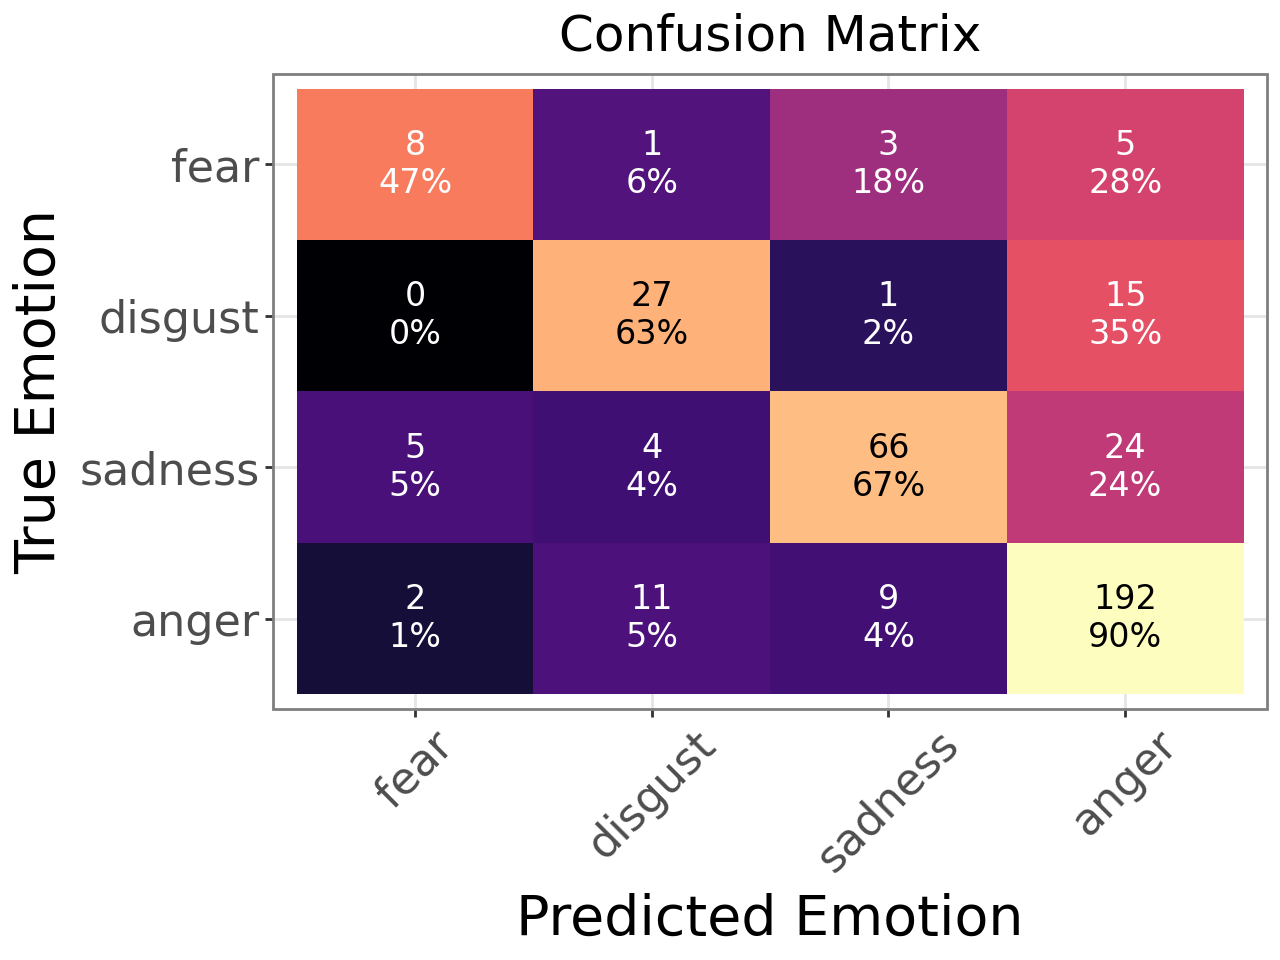

In [8]:
utils.print_confusion_matrix(
    df,
    target_labels=meld_negative_emotions,
    output_column="output",
    target_column="target",
)

In den negativen Emotionen kommt es insbesondere bei Wut und Frustration zu Verwechselungen.
Trauer kann sehr gut von Wut auseinandergehalten werden, hier kommt es kaum zu Verwechselungen.

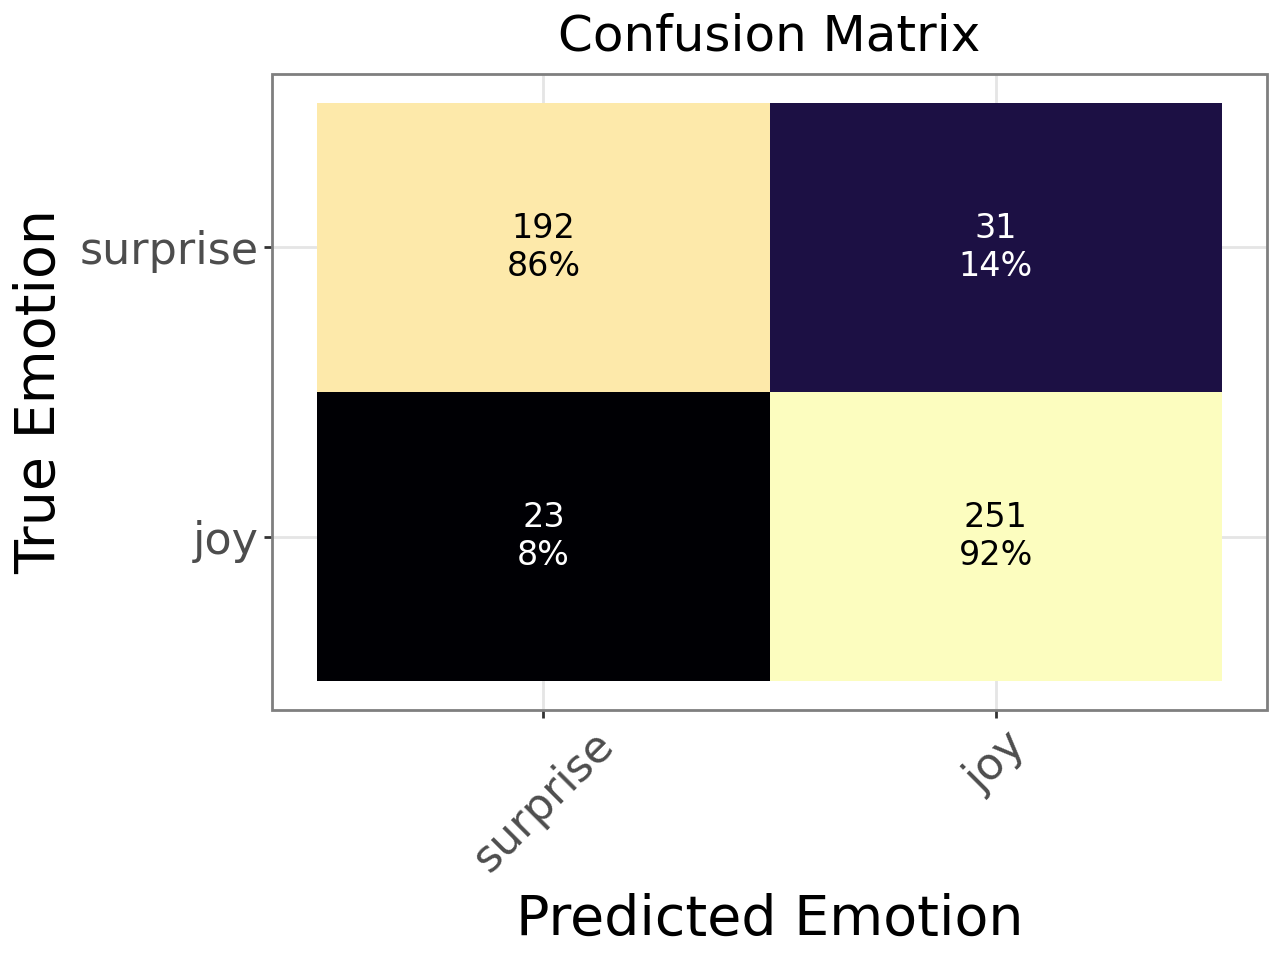

In [9]:
utils.print_confusion_matrix(
    df,
    target_labels=meld_positive_emotions,
    output_column="output",
    target_column="target",
)

In der positiven Gruppe kommt es zu ähnlich häufigen Verwechselungen zwischen Aufgeregt udn Glücklich.
Zu beachten ist aber, dass "Glücklich" mit 143 Beispielen die am wenigsten vertretene Emotion im Datensatz.

TODO: Gucken, wie oft happy für excited von mindestens einem annotator vorgeschlagen wurde.

Weiter wird untersucht, worin die Veränderungen bestehen.
Geguckt wird, wieviele Beispiele jetzt nicht mehr erkannt werden und wie viele jetzt erkannt werden.

In [10]:
both_correct_but_not_text = df[(df["output"] == df["target"]) & (df["output_ierc"] != df["target"])]
text_correct_but_not_both = df[(df["output_ierc"] == df["target"]) & (df["output"] != df["target"])]


print(f"Nach dem Hinzufügen der Akustik können {len(both_correct_but_not_text)} Beispiele erkannt werden, die vorher nicht erkannt wurden")
print(f"Nach dem Hinzufügen der Akustik können {len(text_correct_but_not_both)} Beispiele nicht mehr richtig erkannt werden")

Nach dem Hinzufügen der Akustik können 315 Beispiele erkannt werden, die vorher nicht erkannt wurden
Nach dem Hinzufügen der Akustik können 156 Beispiele nicht mehr richtig erkannt werden


Es zeigt sich, dass das Modell fast so viele Beispiele nicht mehr richtig erkennt, wie es jetzt neu erkennt.
Dies erklärt den nur leicht gestiegenen F1-Score.


#### Veränderung der Emotionen

Wie sieht die Veränderung zwischen den Emotionen aus?
Dafür werden zuerst die F1-Scores im Vergleich vorher - nachher gezeigt, um zu sehen, ob es Veränderungen in den einzelnen Emotionen gab.

In [11]:
for label in labels:
    y_true = df["target"].apply(lambda x: 1 if x == label else 0)
    y_pred = df["output"].apply(lambda x: 1 if x == label else 0)
    y_pred_ierc = df["output_ierc"].apply(lambda x: 1 if x == label else 0)

    f1_label = f1_score(y_true, y_pred) * 100
    f1_label_ierc = f1_score(y_true, y_pred_ierc) * 100
    
    print(f"F1-Score für Label {label}: {f1_label:.2f} - Vorher: {f1_label_ierc:.2f} - Differenz: {(f1_label - f1_label_ierc):.2f}")

F1-Score für Label neutral: 81.16 - Vorher: 75.84 - Differenz: 5.32
F1-Score für Label joy: 65.45 - Vorher: 61.71 - Differenz: 3.74
F1-Score für Label anger: 60.86 - Vorher: 55.15 - Differenz: 5.70
F1-Score für Label surprise: 63.79 - Vorher: 61.54 - Differenz: 2.25
F1-Score für Label sadness: 43.00 - Vorher: 43.07 - Differenz: -0.07
F1-Score für Label disgust: 44.63 - Vorher: 45.74 - Differenz: -1.12
F1-Score für Label fear: 21.62 - Vorher: 29.20 - Differenz: -7.58


Es gibt leichte Verbesserungen in den Klassen "neutral", "excited", "sad", während leichte Verschlechterungen in den Klassen "frustrated" und "happy" vorkommen.
"angry" hat einen nahezu gleichen Wert.

Als nächstes werden die Änderungen in der Confusion-Matrix analysiert.

c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 7 in image.
c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: images/fusion_meld_diff_cm.png


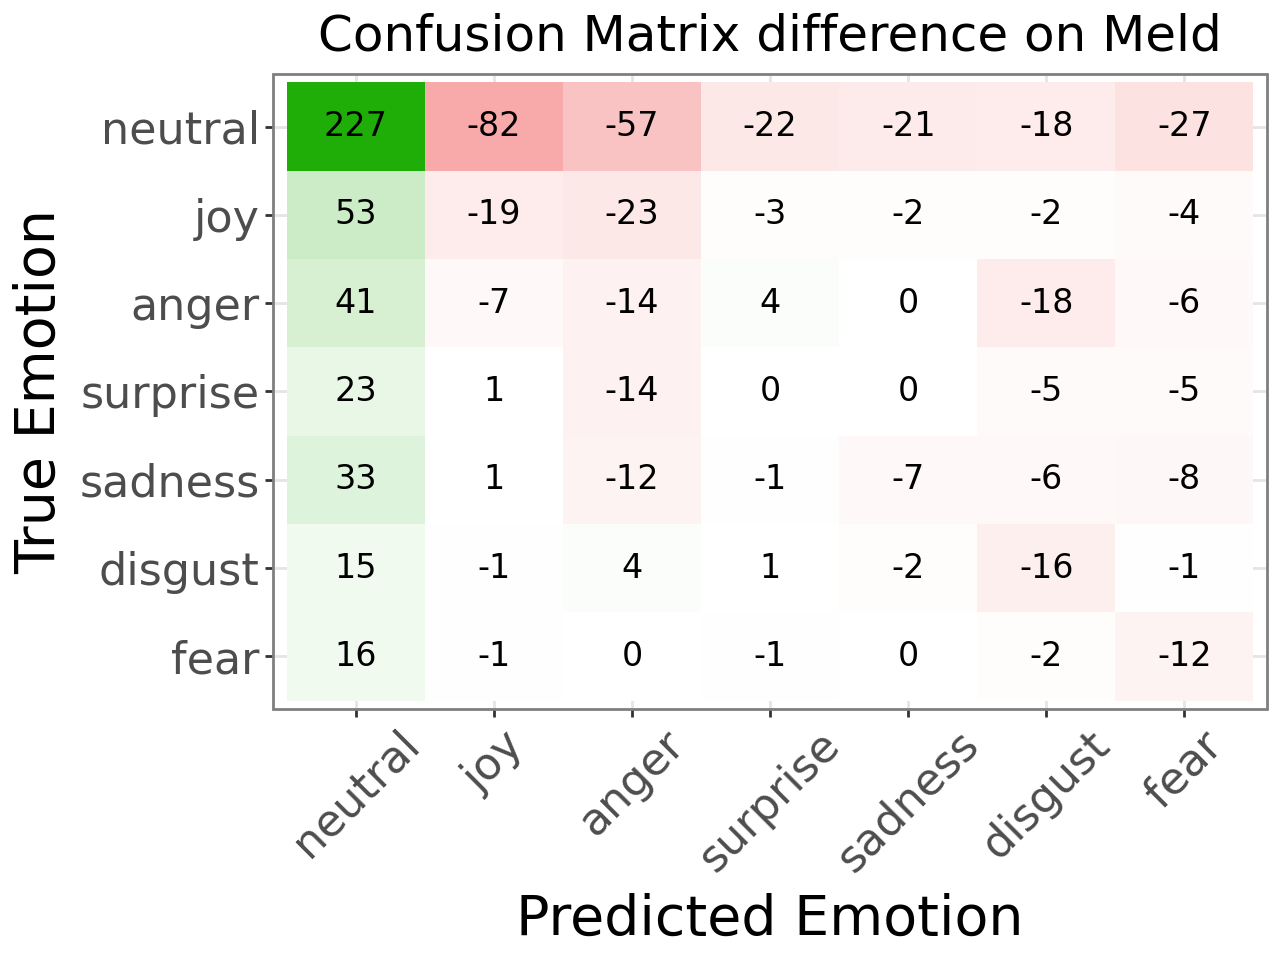

In [12]:
utils.print_confusion_matrix_difference(
    df,
    target_labels=labels[::-1],
    output_column1="output",
    output_column2="output_ierc",
    name="images/fusion_meld_diff_cm.png",
    title="Confusion Matrix difference on Meld",
)

In [13]:
print(
    confusion_matrix(df["target"], df["output"], labels=labels)
    - confusion_matrix(df["target"], df["output_ierc"], labels=labels)
)

[[227 -82 -57 -22 -21 -18 -27]
 [ 53 -19 -23  -3  -2  -2  -4]
 [ 41  -7 -14   4   0 -18  -6]
 [ 23   1 -14   0   0  -5  -5]
 [ 33   1 -12  -1  -7  -6  -8]
 [ 15  -1   4   1  -2 -16  -1]
 [ 16  -1   0  -1   0  -2 -12]]


In [14]:
from sklearn.metrics import precision_score, recall_score

for label in labels:
    y_true = df["target"].apply(lambda x: 1 if x == label else 0)
    y_pred = df["output"].apply(lambda x: 1 if x == label else 0)
    y_pred_ierc = df["output_ierc"].apply(lambda x: 1 if x == label else 0)

    pre_label = precision_score(y_true, y_pred) * 100
    rec_label = recall_score(y_true, y_pred) * 100
    pre_label_ierc = precision_score(y_true, y_pred_ierc) * 100
    rec_label_ierc = recall_score(y_true, y_pred_ierc) * 100
    f1_label = f1_score(y_true, y_pred) * 100
    f1_label_ierc = f1_score(y_true, y_pred_ierc) * 100
    
    print(f"Precision\t für Label {label}: {pre_label:.2f} - Vorher: {pre_label_ierc:.2f} - Differenz: {(pre_label - pre_label_ierc):.2f}")
    print(f"Recall\t\t für Label {label}: {rec_label:.2f} - Vorher: {rec_label_ierc:.2f} - Differenz: {(rec_label - rec_label_ierc):.2f}")
    print(f"F1\t\t für Label {label}: {f1_label:.2f} - Vorher: {f1_label_ierc:.2f} - Different: {(f1_label - f1_label_ierc):.2f}")
    print()

Precision	 für Label neutral: 75.44 - Vorher: 83.11 - Differenz: -7.67
Recall		 für Label neutral: 87.82 - Vorher: 69.75 - Differenz: 18.07
F1		 für Label neutral: 81.16 - Vorher: 75.84 - Different: 5.32

Precision	 für Label joy: 68.77 - Vorher: 57.08 - Differenz: 11.68
Recall		 für Label joy: 62.44 - Vorher: 67.16 - Differenz: -4.73
F1		 für Label joy: 65.45 - Vorher: 61.71 - Different: 3.74

Precision	 für Label anger: 67.13 - Vorher: 51.24 - Differenz: 15.89
Recall		 für Label anger: 55.65 - Vorher: 59.71 - Differenz: -4.06
F1		 für Label anger: 60.86 - Vorher: 55.15 - Different: 5.70

Precision	 für Label surprise: 59.81 - Vorher: 55.98 - Differenz: 3.84
Recall		 für Label surprise: 68.33 - Vorher: 68.33 - Differenz: 0.00
F1		 für Label surprise: 63.79 - Vorher: 61.54 - Different: 2.25

Precision	 für Label sadness: 66.67 - Vorher: 55.73 - Differenz: 10.94
Recall		 für Label sadness: 31.73 - Vorher: 35.10 - Differenz: -3.37
F1		 für Label sadness: 43.00 - Vorher: 43.07 - Different

Dadurch, dass die Klasse neutral besser klassifizietr werden kann, 

Hier lässt sich erkennen, wie die Veränderungen in den F1-Scores zustandegekommen sind.
"Frustration" verliert am meisten Punkte, da es häufiger als "Wut" oder "Trauer" klassifiziert wird.
Dagegen werden "Trauer" und "Wut" jetzt weniger als "Frustration" klassifiziert, dafür häufiger korrekt.
Auch "Aufgeregt" kann nun besser zu einer neutralen Emotion differenziert werden.
Insgesamt kann besser zwischen "Neutral" / keine Emotion, und einer Emotionsklasse differenziert werden.

Wir gucken nun, ob das an der Akustik liegen kann.
- Dafür gucken wir uns die Verteilung von richtig klassifizierten Emotionen einmal aus dem "nur-Text" und einmal dem "nur-Audio" modell an.
- BEtrachten der Beispiele, die vorher falsch und jetzt richtig klassifiziert wurden. Gibt es bei der Akustik hier auch eine erhöhte Trefferrate?

In [15]:
combined_model = df["target"] == df["output"]  # C
text_only_model = df["target"] == df["output_ierc"]  # T
audio_only_model = df["target"] == df["output_audio"]  # A

# Define negations
not_combined_model = ~combined_model
not_text_only_model = ~text_only_model
not_audio_only_model = ~audio_only_model


text_only_false_but_now_correct = df[(not_text_only_model) & (combined_model)]
text_only_false_but_audio_correct = df[
    (not_text_only_model) & (audio_only_model)
]

correct_by_model_and_audio_but_not_text = df[
    combined_model & audio_only_model & not_text_only_model
]

text_correct_but_not_audio_or_both = df[
    text_only_model & not_audio_only_model & not_combined_model
]
text_correct_bot_not_audio = df[text_only_model & not_audio_only_model]

print(
    f"Nach dem Hinzufügen der Akustik können {len(text_only_false_but_now_correct)} Beispiele erkannt werden, die vorher nicht erkannt wurden"
)
print(
    f"Die Akustik kann {len(text_only_false_but_audio_correct)} Beispiele erkennen, die vom Text allein nicht erkannt werden"
)
print(
    f"Insgesamt gibt es {len(correct_by_model_and_audio_but_not_text)} Beispiele, die nicht vom Text, aber vom Modell und der Akustik erkannt werden"
)
print(
    f"Insgesamt gibt es {len(text_correct_but_not_audio_or_both)} Beispiele, die nur vom Text, nicht aber vom Modell und der Akustik erkannt werden"
)
print(
    f"InstructERC kann {len(text_correct_bot_not_audio)} Beispiele richtig klassifizieren, die die Akustik nicht klassifizieren kann"
)

Nach dem Hinzufügen der Akustik können 315 Beispiele erkannt werden, die vorher nicht erkannt wurden
Die Akustik kann 381 Beispiele erkennen, die vom Text allein nicht erkannt werden
Insgesamt gibt es 232 Beispiele, die nicht vom Text, aber vom Modell und der Akustik erkannt werden
Insgesamt gibt es 148 Beispiele, die nur vom Text, nicht aber vom Modell und der Akustik erkannt werden
InstructERC kann 783 Beispiele richtig klassifizieren, die die Akustik nicht klassifizieren kann


Um zu gucken, ob die Akustik Anteile an der "positiven" Veränderung in der Klassifizierung hat, wird der Anteil der Emotionen berechnet aus der Untermenge der Beispiele, die nicht vom InstructERC Modell aber von der Akustik und dem gemischten Modell richtig klassifiziert werden konnten.

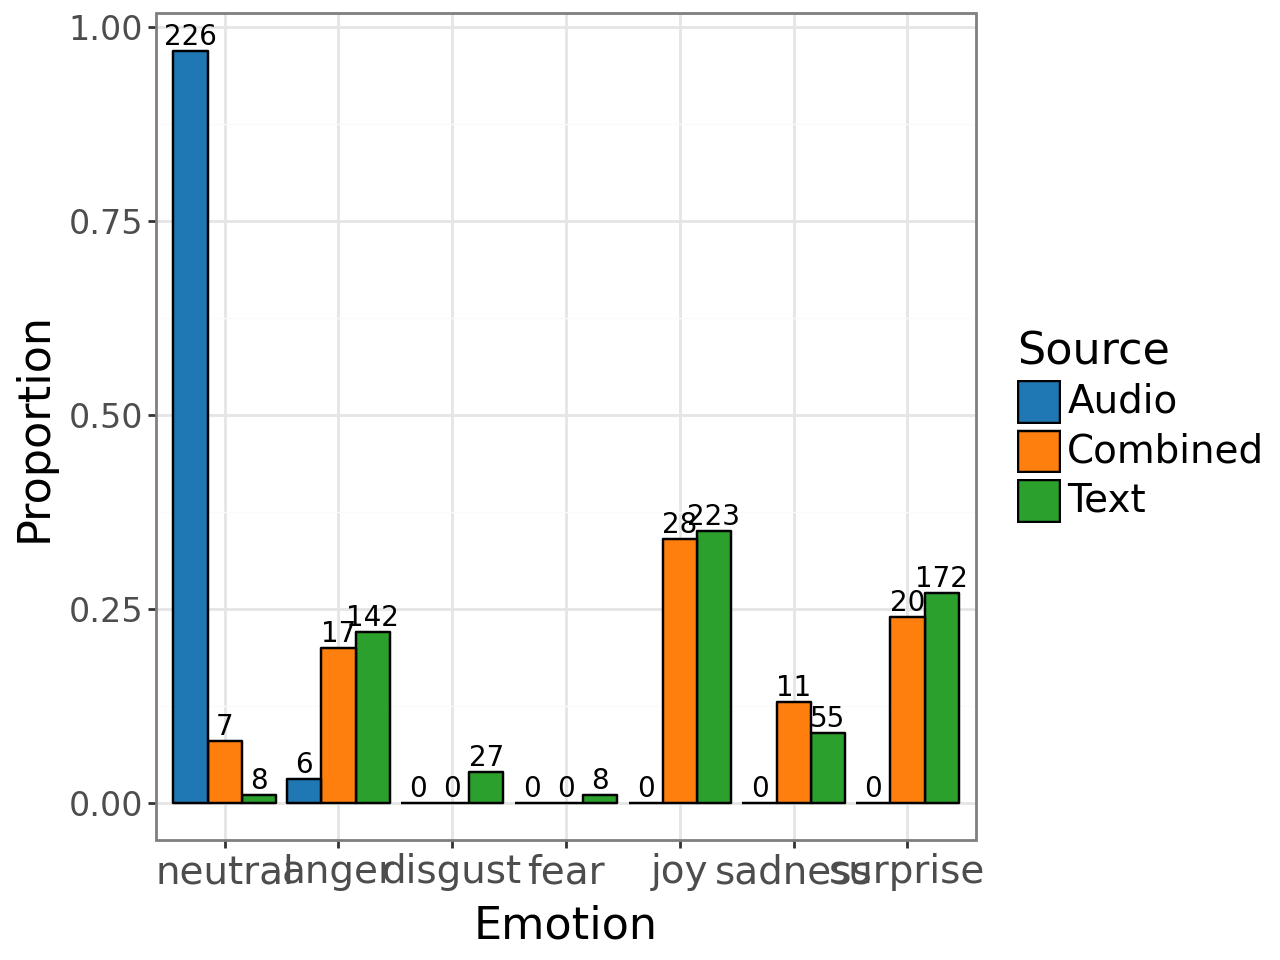

c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 10 x 5 in image.
c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: images/fusion_meld_proportions.png


In [16]:
from plotnine import (
    aes,
    element_text,
    geom_col,
    geom_text,
    ggplot,
    labs,
    position_dodge,
    scale_fill_brewer,
    scale_fill_manual,
    theme,
    theme_bw,
    xlab,
    ylab,
)

correct_by_model_and_audio_but_not_text = df[
    (combined_model) & (not_text_only_model) & (audio_only_model)
]

correct_by_model_and_text_but_not_audio = df[
    combined_model & not_audio_only_model & text_only_model
]

correct_by_model_only = df[
    (combined_model) & (not_audio_only_model) & (not_text_only_model)
]


proportions = correct_by_model_and_audio_but_not_text.value_counts(
    "target", normalize=False
).to_frame(name="Audio")
proportions = (
    proportions.merge(
        correct_by_model_and_text_but_not_audio.value_counts(
            "target", normalize=False
        ).to_frame(name="Text"),
        how="outer",
        on="target",
    )
    .merge(
        correct_by_model_only.value_counts("target", normalize=False).to_frame(
            name="Combined"
        ),
        how="outer",
        on="target",
    )
    .reset_index()
)



proportions = proportions.melt(
    id_vars="target",
    value_vars=["Audio", "Text", "Combined"],
    var_name="source",
    value_name="value",
)

proportions["value"] = proportions["value"].fillna(0).astype(int)
proportions["proportion"] = proportions.groupby("source")["value"].transform(
    lambda x: round(x / x.sum(), 2)
)



proportions["target"] = pd.Categorical(
    proportions["target"],
    categories=proportions[proportions["source"] == "Audio"].sort_values(
        by="proportion", ascending=False
    )["target"],
)


p = (
    ggplot(proportions, aes(x="factor(target)", y="proportion", fill="source"))
    + geom_col(position="dodge", color="black")
    + geom_text(
        aes(label="value"),
        va="bottom",
        position=position_dodge(0.9),
        size=10,
    )
    + ylab("Proportion")
    + xlab("Emotion")
    + labs(fill="Source")
    + theme_bw()
    + theme(
        axis_text_x=element_text(size=14),
        axis_text_y=element_text(size=12),
        axis_title=element_text(size=16),
        legend_text=element_text(size=14),
        legend_title=element_text(size=16),
    )
    + scale_fill_manual(values=["#1f77b4", "#ff7f0e", "#2ca02c"])
)

p.show()
p.save("images/fusion_meld_proportions.png", width=10, height=5)
# proportions

In [17]:
df["output_audio"].value_counts()

output_audio
neutral     2511
anger         93
surprise       4
joy            2
Name: count, dtype: int64

In [18]:
df["target"].value_counts()

target
neutral     1256
joy          402
anger        345
surprise     281
sadness      208
disgust       68
fear          50
Name: count, dtype: int64

Wir sahen verbesserungen im Bereich "Excited", "Sad" und "Angry". Anhand der Verteilung exklusiv richtig klassifizierten Emotionen zeigt sich, dass die Akustik große Stärken im Bereich "Frustration" besitzt.
Aber vorallem in den Klassen "Sad" und "Angry" ist die Akustik besser als der Text, was einen Hinweis liefert, dass durch die Hinzunahme der Akustik, diese Klassen besser differenziert werden konnten.

### Weitere Statistiken
Hier werden weitere Statistiken genannt, wie das Klassifizierungsverhalten der einzelnen Teilmodelle ist.
Es wurden einmal die Ergebnisse von InstructERC, dem Early-fusionination Modell mit Fenstergröße 1 und nur audio input, und dem Early-fusionination modell mit vollem Input berechnet.


In [19]:
both_correct = df[combined_model]
both_not_correct = df[not_combined_model]
text_correct = df[text_only_model]
text_not_correct = df[not_text_only_model]
text_correct_but_not_both = df[text_only_model & not_combined_model]
both_correct_but_not_text = df[combined_model & not_text_only_model]
text_and_both_correct = df[text_only_model & combined_model]
text_and_both_not_correct = df[not_text_only_model & not_combined_model]


print(f"Vom kombinierten modell konnten {len(both_correct)} Beispiele erkannt werden")
print(f"Vom kombinierten modell konnten {len(both_not_correct)} Beispiele nicht erkannt werden")
print(f"Vom Text konnten {len(text_correct)} Beispiele erkannt werden")
print(f"Vom Text konnten {len(text_not_correct)} Beispiele nicht erkannt werden")
print(f"Vom Text konnten {len(text_correct_but_not_both)} Beispiele erkannt werden, die nicht vom kombinierten erkannt wurden")
print(f"Vom kombinierten konnten {len(both_correct_but_not_text)} Beispiele erkannt werden, die nicht vom text erkannt wurden")
print(f"Vom Text und kombinierten konnten {len(text_and_both_correct)} gemiensame Beispiele erkannt werden")

Vom kombinierten modell konnten 1839 Beispiele erkannt werden
Vom kombinierten modell konnten 771 Beispiele nicht erkannt werden
Vom Text konnten 1680 Beispiele erkannt werden
Vom Text konnten 930 Beispiele nicht erkannt werden
Vom Text konnten 156 Beispiele erkannt werden, die nicht vom kombinierten erkannt wurden
Vom kombinierten konnten 315 Beispiele erkannt werden, die nicht vom text erkannt wurden
Vom Text und kombinierten konnten 1524 gemiensame Beispiele erkannt werden


In [20]:
# Existing statistics
text_correct_bot_not_audio = df[(text_only_model) & (not_audio_only_model)]
audio_only_correct = df[(not_text_only_model) & (audio_only_model)]
both_only_correct = df[
    (combined_model) & (not_audio_only_model) & (not_text_only_model)
]
text_correct_but_not_both = df[(text_only_model) & (not_combined_model)]
audio_correct_but_not_both = df[(audio_only_model) & (not_combined_model)]
text_correct_but_not_audio_and_both = df[
    (text_only_model) & (not_audio_only_model) & (not_combined_model)
]
audio_correct_but_not_text_and_both = df[
    (audio_only_model) & (not_text_only_model) & (not_combined_model)
]

# Print existing statistics
print(
    f"Es konnten {len(text_correct_bot_not_audio)} Datenpunkte nur vom text-only Modell erkannt werden, nicht aber vom audio-only."
)
print(
    f"Es konnten {len(audio_only_correct)} Datenpunkte nur vom audio-only Modell erkannt werden, nicht aber vom text-only."
)
print(
    f"Es konnten {len(both_only_correct)} Datenpunkte nur durch gemeinsamen Input erkannt werden."
)
print(
    f"Es konnten {len(text_correct_but_not_both)} Datenpunkte nur durch text-only erkannt werden, nicht aber durch gemeinsamen Input."
)
print(
    f"Es konnten {len(audio_correct_but_not_both)} Datenpunkte nur durch audio-only erkannt werden, nicht aber durch gemeinsamen Input."
)
print(
    f"Es konnten {len(text_correct_but_not_audio_and_both)} Datenpunkte nur durch text-only erkannt werden, aber weder durch audio-only noch durch gemeinsamen Input."
)
print(
    f"Es konnten {len(audio_correct_but_not_text_and_both)} Datenpunkte nur durch audio-only erkannt werden, aber weder durch text-only noch durch gemeinsamen Input."
)

# Additional statistics

# 1. Alle Modelle haben die Zielvorhersage korrekt erkannt
all_correct = df[(text_only_model) & (audio_only_model) & (combined_model)]
print(
    f"Es konnten {len(all_correct)} Datenpunkte von allen Modellen korrekt erkannt werden. (Schnittmenge)"
)

# 2. Keines der Modelle hat die Zielvorhersage korrekt erkannt
all_incorrect = df[
    (not_text_only_model) & (not_audio_only_model) & (not_combined_model)
]
print(
    f"Es konnten {len(all_incorrect)} Datenpunkte von keinem Modell korrekt erkannt werden."
)

# 3. Text-only und Audio-only Modelle sind korrekt, aber das kombinierte Modell ist falsch
text_and_audio_correct_but_not_combined = df[
    (text_only_model) & (audio_only_model) & (not_combined_model)
]
print(
    f"Es konnten {len(text_and_audio_correct_but_not_combined)} Datenpunkte nur durch text-only und audio-only korrekt erkannt werden, aber nicht durch gemeinsamen Input."
)

# 4. Text-only und kombiniert Modelle sind korrekt, aber das Audio-only Modell ist falsch
text_and_combined_correct_but_not_audio = df[
    (text_only_model) & (combined_model) & (not_audio_only_model)
]
print(
    f"Es konnten {len(text_and_combined_correct_but_not_audio)} Datenpunkte nur durch text-only und gemeinsamen Input korrekt erkannt werden, aber nicht durch audio-only."
)

# 5. Audio-only und kombiniert Modelle sind korrekt, aber das Text-only Modell ist falsch
audio_and_combined_correct_but_not_text = df[
    (audio_only_model) & (combined_model) & (not_text_only_model)
]
print(
    f"Es konnten {len(audio_and_combined_correct_but_not_text)} Datenpunkte nur durch audio-only und gemeinsamen Input korrekt erkannt werden, aber nicht durch text-only."
)

not_combined_but_text_or_audio = df[
    (not_combined_model) & ((text_only_model) | (audio_only_model))
]

print(
    f"Es konnten {len(not_combined_but_text_or_audio)} Datenpunkte nicht durch gemeinsamen Input erkannt werden, obwohl entweder audio-only oder text-only es erkennen konnten"
)

Es konnten 783 Datenpunkte nur vom text-only Modell erkannt werden, nicht aber vom audio-only.
Es konnten 381 Datenpunkte nur vom audio-only Modell erkannt werden, nicht aber vom text-only.
Es konnten 83 Datenpunkte nur durch gemeinsamen Input erkannt werden.
Es konnten 156 Datenpunkte nur durch text-only erkannt werden, nicht aber durch gemeinsamen Input.
Es konnten 157 Datenpunkte nur durch audio-only erkannt werden, nicht aber durch gemeinsamen Input.
Es konnten 148 Datenpunkte nur durch text-only erkannt werden, aber weder durch audio-only noch durch gemeinsamen Input.
Es konnten 149 Datenpunkte nur durch audio-only erkannt werden, aber weder durch text-only noch durch gemeinsamen Input.
Es konnten 889 Datenpunkte von allen Modellen korrekt erkannt werden. (Schnittmenge)
Es konnten 466 Datenpunkte von keinem Modell korrekt erkannt werden.
Es konnten 8 Datenpunkte nur durch text-only und audio-only korrekt erkannt werden, aber nicht durch gemeinsamen Input.
Es konnten 635 Datenpunkt

In [21]:
# 1. Combined Model (C)
df_C = df[combined_model]
print(f"In total, {len(df_C)} samples were recognized by the combined model.")

# 2. Text-Only Model (T)
df_T = df[text_only_model]
print(f"In total, {len(df_T)} samples were recognized by the text-only model.")

# 3. Audio-Only Model (A)
df_A = df[audio_only_model]
print(f"In total, {len(df_A)} samples were recognized by the audio-only model.")

# 4. NOT Combined Model (¬C)
df_not_C = df[not_combined_model]
print(f"In total, {len(df_not_C)} samples were NOT recognized by the combined model.")

# 5. NOT Text-Only Model (¬T)
df_not_T = df[not_text_only_model]
print(f"In total, {len(df_not_T)} samples were NOT recognized by the text-only model.")

# 6. NOT Audio-Only Model (¬A)
df_not_A = df[not_audio_only_model]
print(f"In total, {len(df_not_A)} samples were NOT recognized by the audio-only model.")

# 7. Combined AND Text-Only Models (C ∧ T)
df_C_and_T = df[combined_model & text_only_model]
print(f"In total, {len(df_C_and_T)} samples were recognized by both the combined and text-only models.")

# 8. Combined AND Audio-Only Models (C ∧ A)
df_C_and_A = df[combined_model & audio_only_model]
print(f"In total, {len(df_C_and_A)} samples were recognized by both the combined and audio-only models.")

# 9. Text-Only AND Audio-Only Models (T ∧ A)
df_T_and_A = df[text_only_model & audio_only_model]
print(f"In total, {len(df_T_and_A)} samples were recognized by both the text-only and audio-only models.")

# 10. Combined AND NOT Text-Only Models (C ∧ ¬T)
df_C_and_not_T = df[combined_model & not_text_only_model]
print(f"In total, {len(df_C_and_not_T)} samples were recognized by the combined model but NOT by the text-only model.")

# 11. Combined AND NOT Audio-Only Models (C ∧ ¬A)
df_C_and_not_A = df[combined_model & not_audio_only_model]
print(f"In total, {len(df_C_and_not_A)} samples were recognized by the combined model but NOT by the audio-only model.")

# 12. Text-Only AND NOT Combined Models (T ∧ ¬C)
df_T_and_not_C = df[text_only_model & not_combined_model]
print(f"In total, {len(df_T_and_not_C)} samples were recognized by the text-only model but NOT by the combined model.")

# 13. Text-Only AND NOT Audio-Only Models (T ∧ ¬A)
df_T_and_not_A = df[text_only_model & not_audio_only_model]
print(f"In total, {len(df_T_and_not_A)} samples were recognized by the text-only model but NOT by the audio-only model.")

# 14. Audio-Only AND NOT Combined Models (A ∧ ¬C)
df_A_and_not_C = df[audio_only_model & not_combined_model]
print(f"In total, {len(df_A_and_not_C)} samples were recognized by the audio-only model but NOT by the combined model.")

# 15. Audio-Only AND NOT Text-Only Models (A ∧ ¬T)
df_A_and_not_T = df[audio_only_model & not_text_only_model]
print(f"In total, {len(df_A_and_not_T)} samples were recognized by the audio-only model but NOT by the text-only model.")

# 16. NOT Combined AND NOT Text-Only Models (¬C ∧ ¬T)
df_not_C_and_not_T = df[not_combined_model & not_text_only_model]
print(f"In total, {len(df_not_C_and_not_T)} samples were NOT recognized by both the combined and text-only models.")

# 17. NOT Combined AND NOT Audio-Only Models (¬C ∧ ¬A)
df_not_C_and_not_A = df[not_combined_model & not_audio_only_model]
print(f"In total, {len(df_not_C_and_not_A)} samples were NOT recognized by both the combined and audio-only models.")

# 18. NOT Text-Only AND NOT Audio-Only Models (¬T ∧ ¬A)
df_not_T_and_not_A = df[not_text_only_model & not_audio_only_model]
print(f"In total, {len(df_not_T_and_not_A)} samples were NOT recognized by both the text-only and audio-only models.")

# 19. Combined AND Text-Only AND Audio-Only Models (C ∧ T ∧ A)
df_C_and_T_and_A = df[combined_model & text_only_model & audio_only_model]
print(f"In total, {len(df_C_and_T_and_A)} samples were recognized by the combined, text-only, and audio-only models.")

# 20. Combined AND Text-Only AND NOT Audio-Only Models (C ∧ T ∧ ¬A)
df_C_and_T_and_not_A = df[combined_model & text_only_model & not_audio_only_model]
print(f"In total, {len(df_C_and_T_and_not_A)} samples were recognized by the combined and text-only models but NOT by the audio-only model.")

# 21. Combined AND NOT Text-Only AND Audio-Only Models (C ∧ ¬T ∧ A)
df_C_and_not_T_and_A = df[combined_model & not_text_only_model & audio_only_model]
print(f"In total, {len(df_C_and_not_T_and_A)} samples were recognized by the combined and audio-only models but NOT by the text-only model.")

# 22. Combined AND NOT Text-Only AND NOT Audio-Only Models (C ∧ ¬T ∧ ¬A)
df_C_and_not_T_and_not_A = df[combined_model & not_text_only_model & not_audio_only_model]
print(f"In total, {len(df_C_and_not_T_and_not_A)} samples were recognized by the combined model but NOT by the text-only and audio-only models.")

# 23. NOT Combined AND Text-Only AND Audio-Only Models (¬C ∧ T ∧ A)
df_not_C_and_T_and_A = df[not_combined_model & text_only_model & audio_only_model]
print(f"In total, {len(df_not_C_and_T_and_A)} samples were NOT recognized by the combined model but recognized by both the text-only and audio-only models.")

# 24. NOT Combined AND Text-Only AND NOT Audio-Only Models (¬C ∧ T ∧ ¬A)
df_not_C_and_T_and_not_A = df[not_combined_model & text_only_model & not_audio_only_model]
print(f"In total, {len(df_not_C_and_T_and_not_A)} samples were NOT recognized by the combined and audio-only models but recognized by the text-only model.")

# 25. NOT Combined AND NOT Text-Only AND Audio-Only Models (¬C ∧ ¬T ∧ A)
df_not_C_and_not_T_and_A = df[not_combined_model & not_text_only_model & audio_only_model]
print(f"In total, {len(df_not_C_and_not_T_and_A)} samples were NOT recognized by the combined and text-only models but recognized by the audio-only model.")

# 26. NOT Combined AND NOT Text-Only AND NOT Audio-Only Models (¬C ∧ ¬T ∧ ¬A)
df_not_C_and_not_T_and_not_A = df[not_combined_model & not_text_only_model & not_audio_only_model]
print(f"In total, {len(df_not_C_and_not_T_and_not_A)} samples were NOT recognized by the combined, text-only, and audio-only models.")


In total, 1839 samples were recognized by the combined model.
In total, 1680 samples were recognized by the text-only model.
In total, 1278 samples were recognized by the audio-only model.
In total, 771 samples were NOT recognized by the combined model.
In total, 930 samples were NOT recognized by the text-only model.
In total, 1332 samples were NOT recognized by the audio-only model.
In total, 1524 samples were recognized by both the combined and text-only models.
In total, 1121 samples were recognized by both the combined and audio-only models.
In total, 897 samples were recognized by both the text-only and audio-only models.
In total, 315 samples were recognized by the combined model but NOT by the text-only model.
In total, 718 samples were recognized by the combined model but NOT by the audio-only model.
In total, 156 samples were recognized by the text-only model but NOT by the combined model.
In total, 783 samples were recognized by the text-only model but NOT by the audio-only 

## Gate analysis

1. wie ist die Verteilung der Gate-Werte?
   - wie ist sie gesamt?
   - wie ist sie für Samples, die nur die Akustik erkannt hat?
2. Robustheitstest
   - Verhalten bei verrauschter Akustik
   - Verhalten bei verrauschtem Text

In [22]:
import numpy as np


def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

df["softmax_gate"] = df["gate"].apply(lambda x: softmax(x))
df["text_gate_softmax"] = df["softmax_gate"].apply(lambda x: x[0])
df["audio_gate_softmax"] = df["softmax_gate"].apply(lambda x: x[1])
df["text_gate_pred"] = df["gate"].apply(lambda x: sigmoid(x[0]))
df["audio_gate_pred"] = df["gate"].apply(lambda x: sigmoid(x[1]))
df.head(1)

,input,output,target,certainty,gate,input_audio,output_audio,certainty_audio,input_ierc,output_ierc,...,output_text,certainty_text,any_correct,emotion_sentiment,emotion_sentiment_prediction,softmax_gate,text_gate_softmax,audio_gate_softmax,text_gate_pred,audio_gate_pred
index,,,,,,,,,,,,,,,,,,,,,
0,Now you are expert of sentiment and emotional ...,neutral,surprise,0.631836,"[1.0625, 0.73583984375]",Now you are expert of sentiment and emotional ...,neutral,0.459229,Now you are expert of sentiment and emotional ...,neutral,...,neutral,0.499023,neutral,positive,neutral,"[0.580946520203585, 0.419053479796415]",0.580947,0.419053,0.743168,0.676085


In [23]:
from matplotlib import scale
from plotnine import (
    geom_boxplot,
    geom_violin,
    guides,
    scale_x_continuous,
    scale_x_discrete,
    scale_y_continuous,
    stage,
    ylim,
)


def print_violines(df, vars: list[str], shift=0.2):
    shift = 0.2

    def alt_sign(x):
        "Alternate +1/-1 if x is even/odd"
        return (-1) ** x

    m1 = aes(x=stage("gate_type", after_scale="x+shift*alt_sign(x)"))  # shift outward

    p = (
        ggplot(
            df.melt(
                value_vars=vars,
                var_name="gate_type",
                value_name="gate_value",
            ),
            aes(y="gate_value", x="gate_type", fill="gate_type"),
        )
        + geom_violin(m1, style="left-right", scale="width")
        + geom_boxplot(width=shift)
        + guides(fill=False)
        + scale_x_discrete(expand=(0.2, 0), labels=["Audio", "Text"])
        + xlab("Gate Target")
        + ylab("Gate Prediction")
        + theme_bw()
        + theme(
            aspect_ratio=1,
            axis_title=element_text(size=24),
            axis_text=element_text(size=22),
            plot_margin=0
        )
        + scale_y_continuous(breaks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], limits=(0, 1))
    )

    p.show()
    return p



In [24]:
print_violines(df, ["text_gate_pred", "audio_gate_pred"]).save(
    "images/gate_dist_normal_meld.png", width=8, height=6, dpi=300
)

print_violines(
    df[combined_model & audio_only_model & not_text_only_model],
    ["text_gate_pred", "audio_gate_pred"],
).save("images/gate_dist_audio_only_meld.png", width=8, height=6, dpi=300)

print_violines(
    df[combined_model & text_only_model & not_audio_only_model],
    ["text_gate_pred", "audio_gate_pred"],
).save("images/gate_dist_text_only_meld.png", width=8, height=6, dpi=300)

KeyboardInterrupt: 

In [184]:
from scipy.stats import ttest_ind, ttest_rel

ttest_ind(df["text_gate_pred"], df["audio_gate_pred"])

TtestResult(statistic=35.497311804462406, pvalue=2.0263489623256947e-247, df=5218.0)

Genauigkeit des Gates: 

In [171]:
df["gate_audio_correct"] = (
    (df["audio_gate_pred"] > 0.5) & (df["output_audio"] == df["target"])
) | ((df["audio_gate_pred"] < 0.5) & (df["output_audio"] != df["target"]))

df["gate_text_correct"] = (df["text_gate_pred"] > 0.5) & (
    df["output_text"] == df["target"]
) | ((df["text_gate_pred"] < 0.5) & (df["output_text"] != df["target"]))

print("Accuracy on audio-only model:", df["gate_audio_correct"].mean())
print("Accuracy on text-only model:", df["gate_text_correct"].mean())

Accuracy on audio-only model: 0.7597701149425288
Accuracy on text-only model: 0.6980842911877395


#### Gate robustness

In [172]:
import os

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoConfig, AutoProcessor, AutoTokenizer

from utils.collator import SequenceClassificationCollator
from utils.dataset import ERCDataset, MeldDataset
from utils.model import MmLlamaConfig, MmLlamaForSequenceClassification
from utils.processor import MmLlamaProcessor

LLM_ID = os.path.abspath("../../models/language/LLaMA2-base")
LLM_ADAPTER = os.path.abspath("../../models/language/adapter/meld/LLaMA2-base")
MODEL_PATH = os.path.abspath("../../experiments/multimodal/late_fusion/final/meld/LLaMA2-base/final_version/stage_3")
ACOUSTIC_MODEL = os.path.abspath("../../models/acoustic/wav2vec2/wav2vec2-large-robust-12-ft-emotion-msp-dim")
DATASET_PATH = os.path.abspath("../../datasets/meld/test_sent_emo.csv")


In [173]:
def load_tokenizer():
    tokenizer = AutoTokenizer.from_pretrained(LLM_ID)
    tokenizer.pad_token_id = tokenizer.unk_token_id
    tokenizer.padding_side = "left"
    return tokenizer


def load_model_for_test(model: MmLlamaForSequenceClassification):
    model.load_state_dict(
        torch.load(os.path.join(MODEL_PATH, "best_model.pth")), strict=False
    )

    return model.cuda(0)


def setup_config_and_processor(dataset: ERCDataset):
    # Load configurations
    llm_config = AutoConfig.from_pretrained(LLM_ID)
    ac_config = AutoConfig.from_pretrained(ACOUSTIC_MODEL)
    ac_processor = AutoProcessor.from_pretrained(ACOUSTIC_MODEL)

    # setup of tokenizer
    tokenizer = load_tokenizer()

    # setup of processor
    processor = MmLlamaProcessor(ac_processor, tokenizer)

    # setup of config
    config = MmLlamaConfig(
        llm_config=llm_config,
        audio_config=ac_config,
        pad_token_id=tokenizer.pad_token_id,
        llm_pretrained_adapter=LLM_ADAPTER,
        num_labels=len(dataset.emotions),
    )

    return tokenizer, processor, config


def prepare_batch(batch: dict[str, dict[str, torch.Tensor]]):
    for k in batch:
        if type(batch[k]) is torch.Tensor:
            batch[k] = batch[k].cuda(0)
            continue
        for kk in batch[k]:
            batch[k][kk] = batch[k][kk].cuda(0)

    return batch


def run_model(
    model: MmLlamaForSequenceClassification,
    dataloader: DataLoader,
):
    eval_batch_iterator = tqdm(dataloader, total=len(dataloader), desc="Evaluating")
    model.eval()
    for inputs in eval_batch_iterator:
        with torch.no_grad():
            inputs = prepare_batch(inputs)
            model(**inputs)


In [174]:
# test_dataset = MeldDataset(
#     DATASET_PATH,
#     mode="test",
#     audio_placement="none",
#     task="normal",
#     window=12,
# )

# tokenizer, processor, config = setup_config_and_processor(test_dataset)

# model = MmLlamaForSequenceClassification(config)
# model = load_model_for_test(model)

Applying noise to audio:

In [175]:
# all_gates = []


# def gate_hook(module, inputs, outputs: torch.Tensor):
#     global all_gates
#     all_gates.extend(outputs.cpu().tolist())


# def apply_noise(module, args):
#     data, labels = args
#     data = torch.randn_like(data) + torch.mean(data, dim=1, keepdim=True) * torch.std(
#         data, dim=1, keepdim=True
#     )
#     return (data, labels)


# h1 = model.gate.register_forward_hook(gate_hook)
# h2 = model.audio_projector.register_forward_pre_hook(apply_noise)

# audio_noise_dl = DataLoader(
#     test_dataset,
#     batch_size=8,
#     shuffle=False,
#     num_workers=8,
#     collate_fn=SequenceClassificationCollator(processor, test_dataset),
# )

# run_model(model, audio_noise_dl)

# h1.remove()
# h2.remove()

# df["gate_audio_noise"] = all_gates


Applying noise to text:

In [176]:
# all_gates = []

# h1 = model.gate.register_forward_hook(gate_hook)
# h3 = model.text_projector.register_forward_pre_hook(apply_noise)

# text_noise_dl = DataLoader(
#     test_dataset,
#     batch_size=8,
#     shuffle=False,
#     num_workers=8,
#     collate_fn=SequenceClassificationCollator(processor, test_dataset),
# )

# run_model(model, text_noise_dl)

# h1.remove()
# h3.remove()

# df["gate_text_noise"] = all_gates


In [177]:
# df.to_json(os.path.join(BASE_PATH, DATASET, "meld_gates.json"))
df = pd.read_json(os.path.join(BASE_PATH, DATASET, "meld_gates.json"))
df.head(1)

,input,output,target,certainty,gate,input_audio,output_audio,certainty_audio,input_ierc,output_ierc,...,emotion_sentiment_prediction,softmax_gate,text_gate_softmax,audio_gate_softmax,text_gate_pred,audio_gate_pred,gate_audio_correct,gate_text_correct,gate_audio_noise,gate_text_noise
0,Now you are expert of sentiment and emotional ...,neutral,surprise,0.631836,"[1.0625, 0.7358398438]",Now you are expert of sentiment and emotional ...,neutral,0.459229,Now you are expert of sentiment and emotional ...,neutral,...,neutral,"[0.5809465202, 0.4190534798]",0.580947,0.419053,0.743168,0.676085,False,False,"[-0.0626220703, 1.0693359375]","[1.052734375, 0.0891113281]"


In [178]:
df["text_text_gate_noise_pred"] = df["gate_text_noise"].apply(lambda x: sigmoid(x[0]))
df["audio_text_gate_noise_pred"] = df["gate_text_noise"].apply(lambda x: sigmoid(x[1]))
df["text_audio_gate_noise_pred"] = df["gate_audio_noise"].apply(lambda x: sigmoid(x[0]))
df["audio_audio_gate_noise_pred"] = df["gate_audio_noise"].apply(lambda x: sigmoid(x[1]))

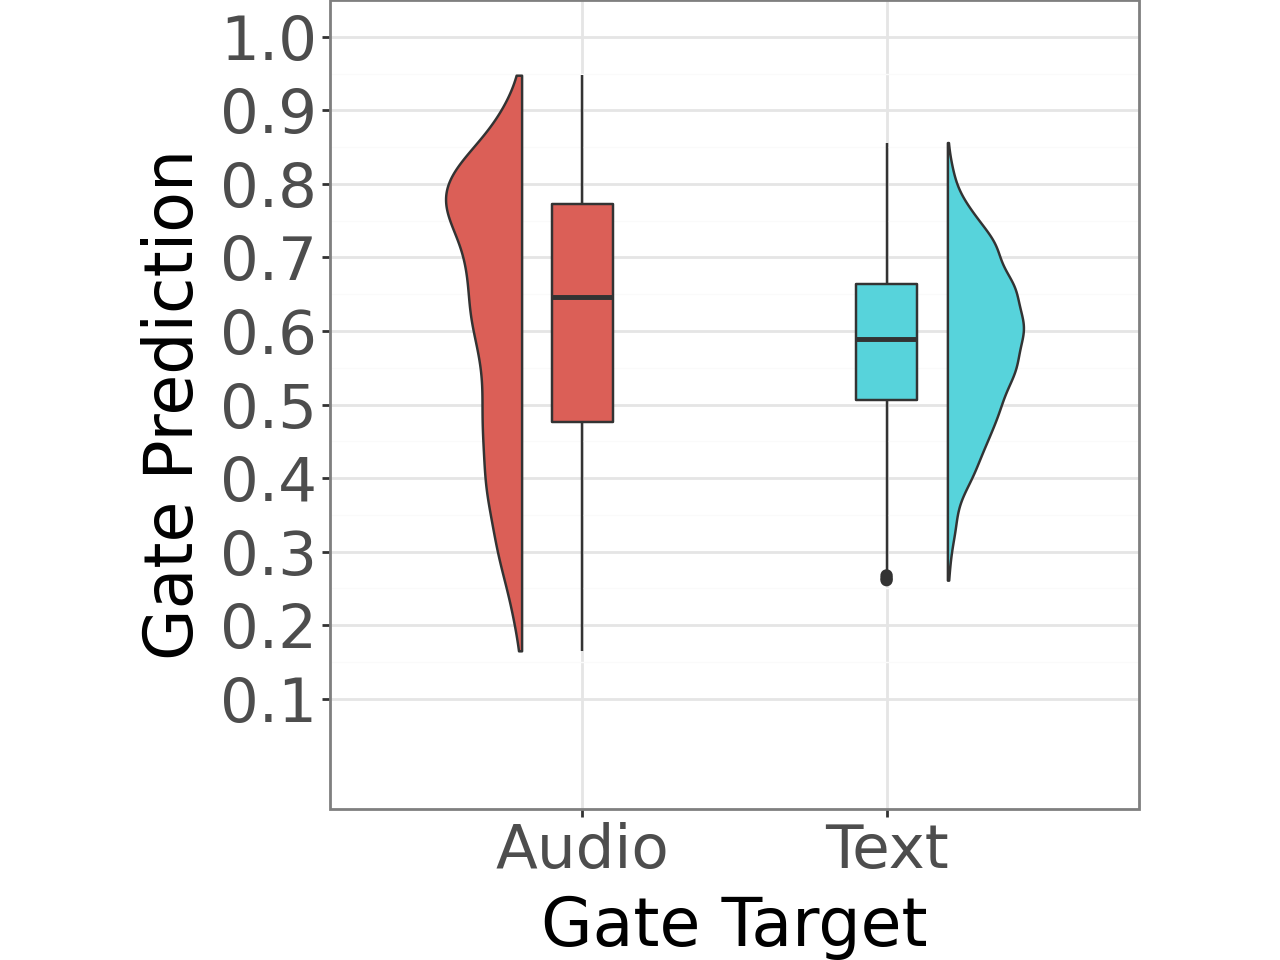

c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: images/gate_dist_audio_noise_meld


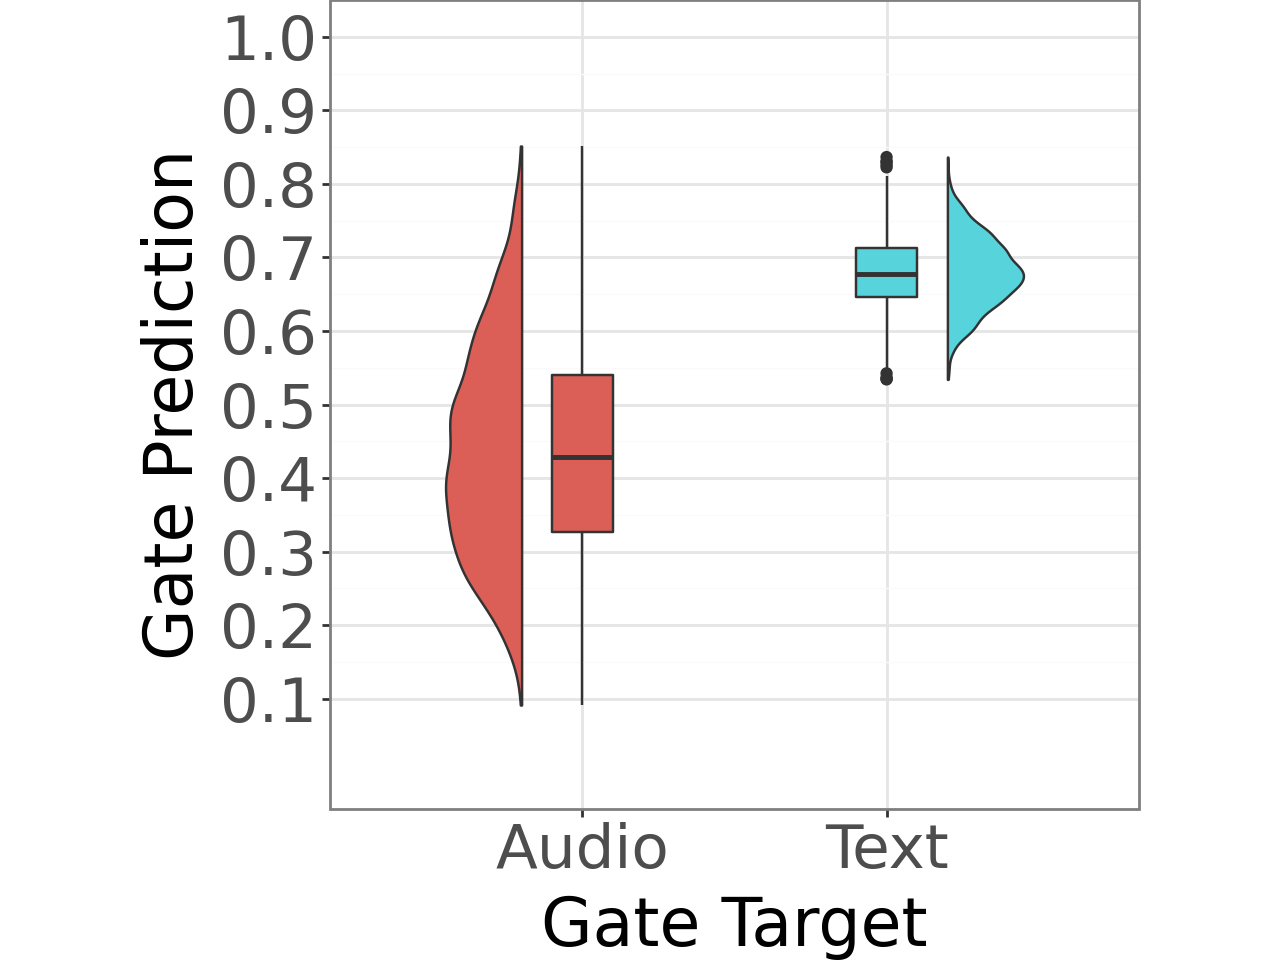

c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
c:\Workspace\Repos\Code_Masterarbeit\Masterarbeit\.conda\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: images/gate_dist_text_noise_meld


In [179]:
print_violines(df, ["audio_audio_gate_noise_pred", "text_audio_gate_noise_pred"]).save(
    "images/gate_dist_audio_noise_meld", width=8, height=6, dpi=300
)
print_violines(df, ["text_text_gate_noise_pred", "audio_text_gate_noise_pred"]).save(
    "images/gate_dist_text_noise_meld", width=8, height=6, dpi=300
)


Gate auf 0.5 für beide

In [180]:
import json

from transformers import LlamaTokenizerFast


def evaluate_fixed_gate(
    tokenizer: LlamaTokenizerFast,
    model: MmLlamaForSequenceClassification,
    dataloader: DataLoader,
):
    eval_batch_iterator = tqdm(dataloader, total=len(dataloader), desc="Evaluating")
    all_targets = []
    all_preds = []
    all_inputs = []

    def gate_hook(module, inputs, outputs:torch.Tensor):
        return torch.empty_like(outputs).fill_(0.5)

    hook = model.gate.register_forward_hook(gate_hook)

    running_loss = 0.0
    model.eval()
    for inputs in eval_batch_iterator:
        labels = inputs["labels"]
        with torch.no_grad():
            try:
                inputs = prepare_batch(inputs)
                preds = model(**inputs)
            except TimeoutError:
                print("TimeoutError on input", inputs)
                preds = torch.zeros((inputs["text"]["input_ids"].size(0), 1))

        running_loss += preds.main_loss
        all_preds.extend(preds.logits.cpu())
        all_targets.extend(labels.cpu())
        all_inputs.extend(inputs["text"]["input_ids"].cpu())

    hook.remove()
    running_loss /= len(dataloader)
    all_preds = torch.stack(all_preds[: len(dataloader.dataset)])
    all_targets = all_targets[: len(dataloader.dataset)]
    all_inputs = all_inputs[: len(dataloader.dataset)]

    all_preds_cert = torch.softmax(all_preds, dim=-1).max(dim=-1).values.tolist()
    all_preds = all_preds.argmax(dim=-1).tolist()
    all_inputs = tokenizer.batch_decode(all_inputs, skip_special_tokens=True)

    dataset = dataloader.dataset
    all_preds = list(map(dataset.id2label, all_preds))
    all_targets = list(map(dataset.id2label, all_targets))

    f1 = f1_score(all_targets, all_preds, average="weighted")
    preds_for_eval = []
    for i, (inp, pred, target, cert) in enumerate(
        zip(all_inputs, all_preds, all_targets, all_preds_cert)
    ):
        preds_for_eval.append(
            {
                "index": i,
                "input": inp,
                "output": pred,
                "target": target,
                "certainty": cert,
            }
        )
   
    with open(os.path.join(BASE_PATH, DATASET, "preds_test_fixed_gate.json"), "wt") as f:
        json.dump(preds_for_eval, f)

    return f1, running_loss

In [181]:
# fixed_gate_dl = DataLoader(
#     test_dataset,
#     batch_size=8,
#     shuffle=False,
#     num_workers=8,
#     collate_fn=SequenceClassificationCollator(processor, test_dataset),
# )

# f1, loss = evaluate_fixed_gate(tokenizer, model, fixed_gate_dl)
# print(f"F1 in Test: {f1}")
# print(f"Loss in Test: {loss}")

In [182]:
df_fixed_gate = pd.read_json(os.path.join(BASE_PATH, DATASET, "preds_test_fixed_gate.json")).set_index("index")
df_fixed_gate.head(1)

,input,output,target,certainty
index,,,,
0,Now you are expert of sentiment and emotional ...,neutral,surprise,0.663086


In [183]:
f1_score(df_fixed_gate["target"], df_fixed_gate["output"], average="weighted")

0.6726458994137144